<a href="https://colab.research.google.com/github/mlvssyaswanth/colab-files/blob/main/stockmarketprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define dataset paths
zip_path = '/content/drive/MyDrive/stock_market.zip'
extract_path = '/content/dataset/'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load the dataset
csv_path = os.path.join(extract_path, 'all_stocks_5yr.csv')  # Modify if needed
df = pd.read_csv(csv_path)

# Convert Date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by=['date'])

# Display first few rows
print(df.head())

             date    open      high      low   close   volume Name
0      2013-02-08   15.07   15.1200   14.630   14.75  8407500  AAL
508224 2013-02-08   81.22   81.9300   80.940   81.89   296853  SLG
506965 2013-02-08   78.24   79.0700   78.125   79.07  4632684  SLB
85755  2013-02-08  236.64  238.6924  235.750  238.16   552207  BLK
505706 2013-02-08   89.04   89.4800   88.910   89.16   554948  SJM


In [ ]:
# Calculate Moving Averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Calculate Exponential Moving Average
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['close'])

# Drop NaN values after adding indicators
df.dropna(inplace=True)

# Display updated dataset
print(df.head())


             date      open    high       low     close   volume  Name  \
515778 2013-02-08  161.0600  162.81  160.7900  162.7600  1048639   SPG   
79165  2013-02-08   87.9600   88.67   87.8000   88.2500  1429840   BDX   
514519 2013-02-08   43.9200   43.96   42.0700   42.6700  7888705  SPGI   
80424  2013-02-08   46.6066   46.89   46.5366   46.7333  1263060   BEN   
513260 2013-02-08   43.8900   43.89   43.6300   43.8500  2355131    SO   

           SMA_20     SMA_50     EMA_20     RSI_14  
515778  69.497500  68.446100  68.062165  58.302307  
79165   70.820000  69.916100  69.984816  53.824348  
514519  71.824000  69.131700  67.383405  51.591264  
80424   70.656165  68.484966  65.416728  53.011133  
513260  69.659665  64.598766  63.362754  51.064723  


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define GAN Generator
def build_generator():
    generator = Sequential([
        Dense(128, activation=LeakyReLU(alpha=0.01), input_dim=100),
        Dense(256, activation=LeakyReLU(alpha=0.01)),
        Dense(512, activation=LeakyReLU(alpha=0.01)),
        Dense(1, activation='linear')  # Output single price prediction
    ])
    return generator

# Generate synthetic stock prices
def generate_synthetic_data(generator, n_samples=500):
    noise = np.random.normal(0, 1, (n_samples, 100))
    synthetic_prices = generator.predict(noise)
    return synthetic_prices.flatten()

# Instantiate and compile the generator
generator = build_generator()
generator.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Train GAN (Skipping Discriminator for simplicity)
synthetic_data = generate_synthetic_data(generator, n_samples=len(df))

# Generate synthetic stock prices
synthetic_data = generate_synthetic_data(generator, n_samples=len(df))

# Ensure length matches
synthetic_data = synthetic_data[:len(df)]  # Trim excess values

# Add synthetic data to the original dataset
df['Synthetic_Close'] = synthetic_data

# Display dataset with synthetic data
print(df.tail())


19344/19344 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
19344/19344 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
             date    open    high     low   close    volume  Name   SMA_20  \
147509 2018-02-07   53.38   54.36   52.94   52.97   6496219   CSX  84.7000   
31474  2018-02-07  107.46  109.48  106.56  106.63   1668253   ALB  76.6485   
241494 2018-02-07   10.75   11.04   10.70   10.76  68041787     F  71.8705   
42609  2018-02-07  176.25  180.99  176.00  177.47   5715671  AMGN  79.1070   
619039 2018-02-07   72.70   75.00   72.69   73.86   4534912   ZTS  77.9960   

          SMA_50     EMA_20     RSI_14  Synthetic_Close  
147509  112.4684  84.251759  50.722214        -0.560888  
31474   113.6470  86.383020  51.616657        -0.619916  
241494  113.4782  79.180827  46.184990        -0.540395  
42609   116.5884  88.541701  53.894334        -0.526102  
619039  116.0976  87.143444  49.892657        -0.428191  


In [ ]:
# Select features
features = ['close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI_14', 'Synthetic_Close']
data = df[features].values

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define training data length (80% for training)
training_data_len = int(len(scaled_data) * 0.8)

# Create training dataset
train_data = scaled_data[:training_data_len]
x_train, y_train = [], []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(x_train, y_train, batch_size=32, epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 143s 9ms/step - loss: 0.0019
Epoch 2/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 140s 9ms/step - loss: 0.0018
Epoch 3/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 140s 9ms/step - loss: 0.0018
Epoch 4/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 143s 9ms/step - loss: 0.0018
Epoch 5/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 143s 9ms/step - loss: 0.0018
Epoch 6/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - loss: 0.0018
Epoch 7/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 201s 9ms/step - loss: 0.0019
Epoch 8/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - loss: 0.0018
Epoch 9/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 0.0018
Epoch 10/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 205s 9ms/step - loss: 0.0018
Epoch 11/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 198s 9ms/step - loss: 0.0018
Epoch 12/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 0.0019
Epoch 13/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - loss: 0.0018
Epoch 14/20
15473/15473 ━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
# Create testing dataset
test_data = scaled_data[training_data_len - 60:]

x_test, y_test = [], data[training_data_len:, 0]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])

# Convert to numpy arrays
x_test = np.array(x_test)

# Reshape for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))


In [ ]:
# Make predictions
predictions = model.predict(x_test)

# Reverse scaling
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), len(features)-1))), axis=1))[:, 0]

# Calculate RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'RMSE: {rmse}')


3869/3869 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
RMSE: 128.93840781285525


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate error metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R² Score: {r2:.4f}')  # Closer to 1 means better prediction


MSE: 16625.1130
RMSE: 128.9384
MAE: 56.4321
R² Score: -0.0216


In [ ]:
# Avoid division by zero errors
epsilon = 1e-10

mape = np.mean(np.abs((y_test - predictions) / (y_test + epsilon))) * 100
accuracy = 100 - mape  # Accuracy (higher is better)

print(f'MAPE: {mape:.2f}%')
print(f'Estimated Accuracy: {accuracy:.2f}%')


MAPE: 79.74%
Estimated Accuracy: 20.26%


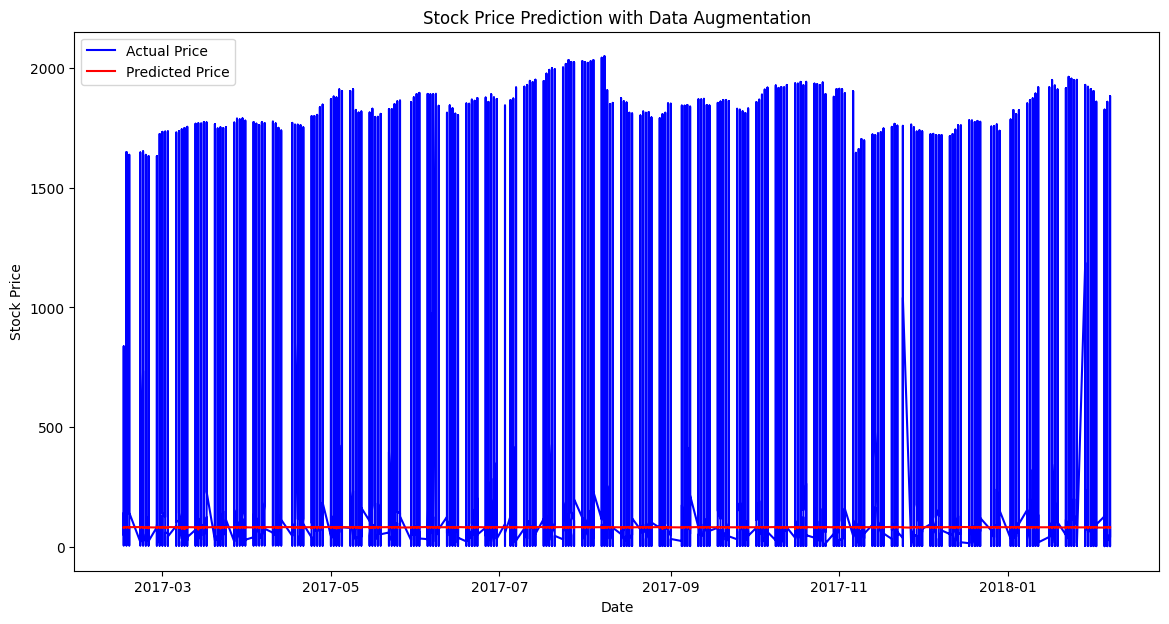

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.title('Stock Price Prediction with Data Augmentation')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(df['date'].iloc[training_data_len:], y_test, label='Actual Price', color='blue')
plt.plot(df['date'].iloc[training_data_len:], predictions, label='Predicted Price', color='red')
plt.legend()
plt.show()